In [1]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
# tf.compat.v1.random.set_random_seed(1234)

In [3]:
df = pd.read_csv('../dataset/apple_train.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/4/2016,102.610001,105.370003,102.000000,105.349998,98.446655,67649400
1,1/5/2016,105.750000,105.849998,102.410004,102.709999,95.979675,55791000
2,1/6/2016,100.559998,102.370003,99.870003,100.699997,94.101387,68457400
3,1/7/2016,98.680000,100.129997,96.430000,96.449997,90.129868,81094400
4,1/8/2016,98.550003,99.110001,96.760002,96.959999,90.606438,70798000


In [4]:
minmax = MinMaxScaler().fit(df.iloc[:, 3:4].astype('float32')) # Low index
df_log = minmax.transform(df.iloc[:, 3:4].astype('float32')) # Low index
df_log = pd.DataFrame(df_log)
df_log.head()

C:\Users\Yingchen\Anaconda3\envs\tf_1.0\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,0
0,0.075097
1,0.077555
2,0.062331
3,0.041714
4,0.043692


## Forecast

This example is using model 1.lstm, if you want to use another model, need to tweak a little bit, but I believe it is not that hard.

I want to forecast 30 days ahead! So just change `test_size` to forecast `t + N` ahead.

Also, I want to simulate 10 times, 10 variances of forecasted patterns. Just change `simulation_size`.

In [5]:
simulation_size = 10
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
test_size = 3
learning_rate = 0.01

df_train = df_log
df.shape, df_train.shape

((968, 7), (968, 1))

In [6]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )
        
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [7]:
# from tensorflow.python.framework import ops

def forecast():
#     ops.reset_default_graph()
    tf.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )        
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))
    
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value = last_state
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.4)
    
    return deep_future

In [8]:
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast())

simulation 1


train loop: 100%|████████████████████| 300/300 [06:10<00:00,  1.24s/it, acc=98.3, cost=0.000671]


simulation 2


C:\Users\Yingchen\Anaconda3\envs\tf_1.0\lib\site-packages\tensorflow\python\client\session.py:1714: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|█████████████████████| 300/300 [07:07<00:00,  1.43s/it, acc=98.3, cost=0.00069]


simulation 3


C:\Users\Yingchen\Anaconda3\envs\tf_1.0\lib\site-packages\tensorflow\python\client\session.py:1714: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|█████████████████████| 300/300 [07:40<00:00,  1.53s/it, acc=97.8, cost=0.00124]


simulation 4


C:\Users\Yingchen\Anaconda3\envs\tf_1.0\lib\site-packages\tensorflow\python\client\session.py:1714: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|████████████████████| 300/300 [08:11<00:00,  1.64s/it, acc=98.4, cost=0.000551]


simulation 5


C:\Users\Yingchen\Anaconda3\envs\tf_1.0\lib\site-packages\tensorflow\python\client\session.py:1714: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|█████████████████████| 300/300 [07:51<00:00,  1.57s/it, acc=98.3, cost=0.00066]


simulation 6


C:\Users\Yingchen\Anaconda3\envs\tf_1.0\lib\site-packages\tensorflow\python\client\session.py:1714: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|████████████████████| 300/300 [07:44<00:00,  1.55s/it, acc=98.4, cost=0.000649]


simulation 7


C:\Users\Yingchen\Anaconda3\envs\tf_1.0\lib\site-packages\tensorflow\python\client\session.py:1714: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|████████████████████| 300/300 [07:25<00:00,  1.48s/it, acc=98.4, cost=0.000626]


simulation 8


C:\Users\Yingchen\Anaconda3\envs\tf_1.0\lib\site-packages\tensorflow\python\client\session.py:1714: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|████████████████████| 300/300 [07:36<00:00,  1.52s/it, acc=98.3, cost=0.000628]


simulation 9


C:\Users\Yingchen\Anaconda3\envs\tf_1.0\lib\site-packages\tensorflow\python\client\session.py:1714: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|█████████████████████| 300/300 [07:20<00:00,  1.47s/it, acc=98.1, cost=0.00078]


simulation 10


C:\Users\Yingchen\Anaconda3\envs\tf_1.0\lib\site-packages\tensorflow\python\client\session.py:1714: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████████████████| 300/300 [07:02<00:00,  1.41s/it, acc=98, cost=0.000912]


In [9]:
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
for i in range(test_size):
    date_ori.append(date_ori[-1] + timedelta(days = 1))
date_ori = pd.Series(date_ori).dt.strftime(date_format = '%Y-%m-%d').tolist()
date_ori[-5:]

['2019-11-04', '2019-11-05', '2019-11-06', '2019-11-07', '2019-11-08']

## Sanity check

Some of our models might not have stable gradient, so forecasted trend might really hangwired. You can use many methods to filter out unstable models.

This method is very simple,
1. If one of element in forecasted trend lower than min(original trend).
2. If one of element in forecasted trend bigger than max(original trend) * 2.

If both are true, reject that trend.

In [10]:
accepted_results = []
for r in results:
    if (np.array(r[-test_size:]) < np.min(df['Low'])).sum() == 0 and \
    (np.array(r[-test_size:]) > np.max(df['Low']) * 2).sum() == 0:
        accepted_results.append(r)
len(accepted_results)

10

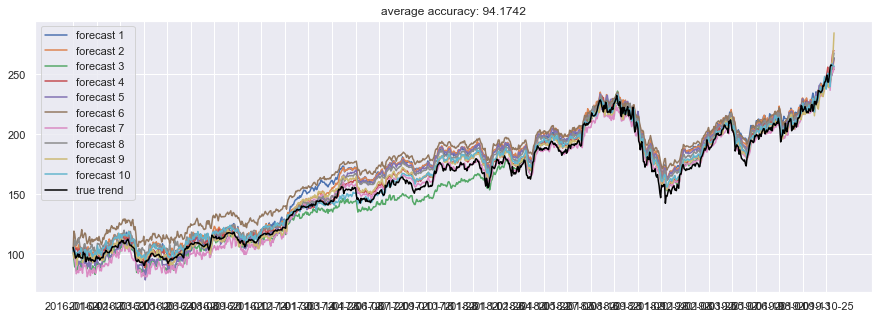

In [11]:
accuracies = [calculate_accuracy(df['Close'].values, r[:-test_size]) for r in accepted_results]

plt.figure(figsize = (15, 5))
for no, r in enumerate(accepted_results):
    plt.plot(r, label = 'forecast %d'%(no + 1))
plt.plot(df['Close'], label = 'true trend', c = 'black')
plt.legend()
plt.title('average accuracy: %.4f'%(np.mean(accuracies)))

x_range_future = np.arange(len(results[0]))
plt.xticks(x_range_future[::30], date_ori[::30])

plt.show()

In [12]:
accepted_results_arr = np.array(accepted_results)
print(accepted_results_arr[:, -3:])

[[254.02140861 255.65265062 255.96523606]
 [254.64728614 256.92597581 263.11559222]
 [259.21192345 260.75771652 263.34824166]
 [266.07883882 269.33785453 269.35072252]
 [255.20723079 259.54895874 263.34631296]
 [250.80862169 255.08528496 253.76092041]
 [252.5001476  251.92301223 255.99700586]
 [260.1052797  263.86534263 267.48843604]
 [260.87681152 270.60269273 284.30397375]
 [258.04419663 257.14949035 256.49188437]]


In [13]:
# apple_true = np.array((256.769989, 258.73999, 258.690002))
apple_true = np.array((257.23999, 259.429993, 260.140015))

In [14]:
# apple_predicted = np.array(accepted_results[:][-4:-1])
# apple_predicted = accepted_results[:][-4:-1]
results_frame = pd.DataFrame(accepted_results)
results_frame.head

<bound method NDFrame.head of      0           1           2           3           4           5    \
0  102.0  101.668430  103.317120  100.410518   95.726047   98.758086   
1  102.0  106.730815  109.118136  106.662058  104.299151  104.710557   
2  102.0   95.488064   89.161313   89.716404   85.795060   84.893200   
3  102.0  104.541363  103.984784  104.730636  103.723088  104.137440   
4  102.0   98.250118  100.651150   97.489920   95.020923   92.798010   
5  102.0  118.966043  116.583291  111.296334  107.490572  108.624039   
6  102.0   99.003705   95.684266   91.715758   83.363451   84.508427   
7  102.0  105.074126  111.075973  111.522527  106.963889  108.859034   
8  102.0   96.398856   98.692666   98.732751   96.868150   90.488690   
9  102.0  104.673840  100.797652   99.617255  101.082248   97.720049   

          6           7           8           9       ...             961  \
0   99.586524  101.518684  102.336140   99.893434     ...      247.652968   
1  104.100102  107.4993

In [15]:
last_3_days = accepted_results_arr[:, -3:]
one_day_errors = []
for index, value in enumerate(apple_true):
    average = np.average(last_3_days[:, index])
    one_day_error = np.absolute((value - average) / value)
    one_day_errors.append(one_day_error)

In [16]:
one_day_errors

[0.0003491506349632706, 0.0025243993751300547, 0.01221195280096048]

In [18]:
results_frame.to_csv('./apple_low_predictions.csv')

In [19]:
one_day_errors_raw = []
for index, value in enumerate(apple_true):
    average = np.average(last_3_days[:, index])
    one_day_error_raw = (value - average) / value
    one_day_errors_raw.append(one_day_error_raw)

In [20]:
one_day_errors_raw

[0.0003491506349632706, -0.0025243993751300547, -0.01221195280096048]

In [21]:
three_day_avg_error = np.average(one_day_errors)
three_day_avg_error_raw = np.average(one_day_errors_raw)

In [22]:
three_day_avg_error

0.005028500937017935

In [23]:
three_day_avg_error_raw

-0.004795733847042421

In [24]:
three_day_exp_error = (one_day_errors[0] + one_day_errors[1] * 2 + one_day_errors[2] * 3) / 6
three_day_exp_error_raw = (one_day_errors_raw[0] + one_day_errors_raw[1] * 2 + one_day_errors_raw[2] * 3) / 6

In [25]:
three_day_exp_error

0.007005634631350804

In [26]:
three_day_exp_error_raw

-0.006889251086363048